In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.tools.plotting import scatter_matrix
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from sklearn.manifold import TSNE



#Clean up data
df=pd.read_csv('abalone.data',names=['Sex','Length','Diameter',
                                      'Height','Whole weight','Shucked weight',
                                      'Viscera weight','Shell weight','Rings'])
#df=pd.concat([pd.get_dummies(df['Sex']),df],axis=1) #one hot encode feature
#del df['Sex']
df=df[df['Height']!=0]
df['Sex']=df['Sex'].apply(lambda x: float(x=='I'))
print df.head()
print df.describe()

#Create train, validation, test sets
X_train, X_test, y_train, y_test=train_test_split(df.values[:,:-1],df.values[:,-1],test_size=.2)
X_train, X_val, y_train, y_val=train_test_split(X_train,y_train,test_size=.25)

print "Training Set Size:",(X_train.shape)
print "Test Set Size:",(X_test.shape)
print "Validation Set Size", X_val.shape

scaler=StandardScaler()
X_train[:,1:]=scaler.fit_transform(X_train[:,1:])
X_test[:,1:]=scaler.transform(X_test[:,1:])
X_val[:,1:]=scaler.transform(X_val[:,1:])


   Sex  Length  Diameter  Height  Whole weight  Shucked weight  \
0  0.0   0.455     0.365   0.095        0.5140          0.2245   
1  0.0   0.350     0.265   0.090        0.2255          0.0995   
2  0.0   0.530     0.420   0.135        0.6770          0.2565   
3  0.0   0.440     0.365   0.125        0.5160          0.2155   
4  1.0   0.330     0.255   0.080        0.2050          0.0895   

   Viscera weight  Shell weight  Rings  
0          0.1010         0.150     15  
1          0.0485         0.070      7  
2          0.1415         0.210      9  
3          0.1140         0.155     10  
4          0.0395         0.055      7  
               Sex       Length    Diameter       Height  Whole weight  \
count  4175.000000  4175.000000  4175.00000  4175.000000   4175.000000   
mean      0.320958     0.524065     0.40794     0.139583      0.829005   
std       0.466901     0.120069     0.09922     0.041725      0.490349   
min       0.000000     0.075000     0.05500     0.010000     

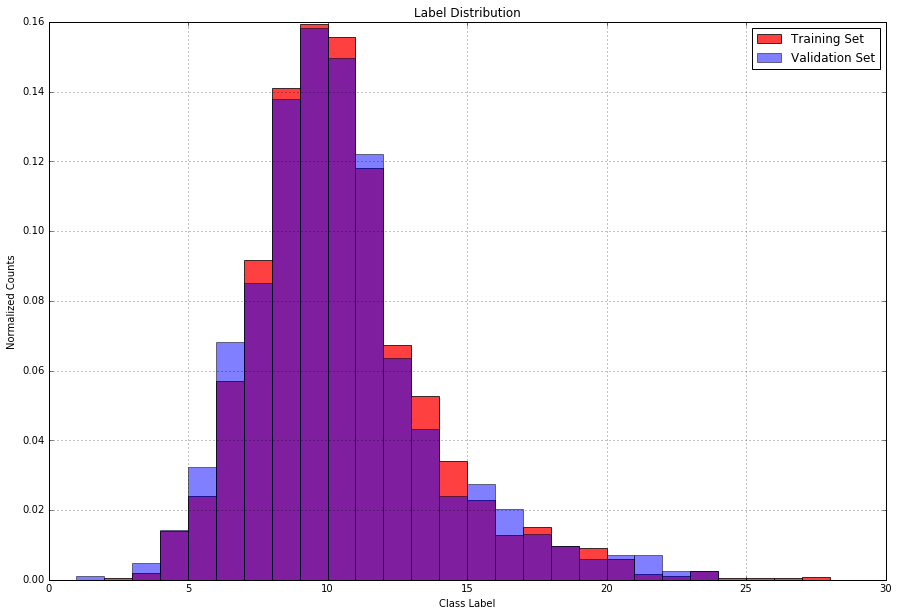

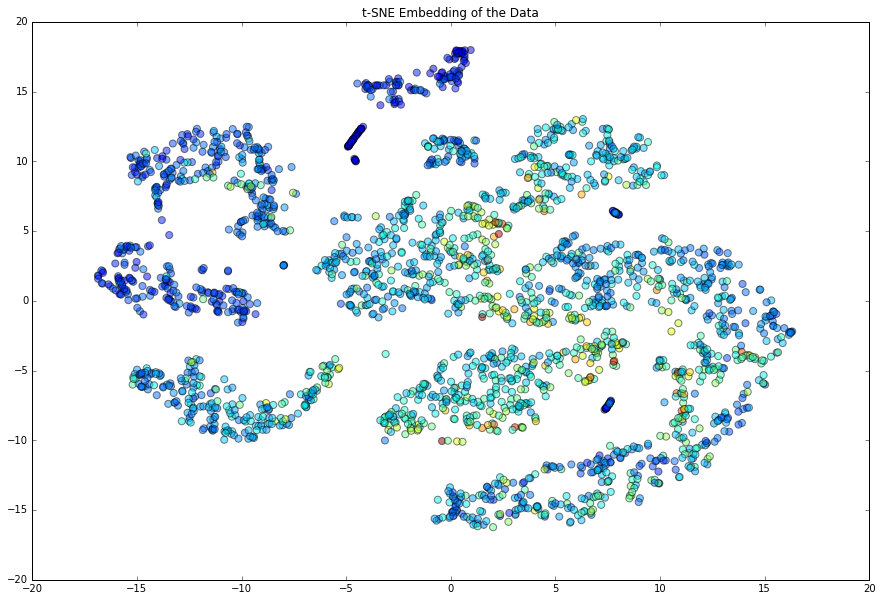

In [2]:
label_counts_train=np.bincount(y_train.astype(np.int))
label_counts_val=np.bincount(y_val.astype(np.int))

label_counts_train=label_counts_train/float(label_counts_train.sum())
label_counts_val=label_counts_val/float(label_counts_val.sum())

ind=np.arange(len(label_counts_train))
_, ax = plt.subplots(figsize=(15,10))
ax.bar(ind,label_counts_train,1, color='r',alpha=.75)
ind=np.arange(len(label_counts_val))
ax.bar(ind,label_counts_val,1, color='b',alpha=.5)
plt.legend(('Training Set','Validation Set'))
plt.xlabel('Class Label')
plt.ylabel('Normalized Counts')
plt.title('Label Distribution')
plt.grid()
plt.show()



model = TSNE(n_components=2,verbose=False)
X_proj=model.fit_transform(X_train)

plt.figure(figsize=(15,10))
plt.scatter(X_proj[:,0],X_proj[:,1],c=y_train,s=50,alpha=.5)
plt.title('t-SNE Embedding of the Data')
plt.show()

In [3]:
def one_hot_labels(y,num_labels):
    return (np.arange(num_labels)==y[:,None]).astype(np.float)


y_train=one_hot_labels(y_train-1,29)
y_test=one_hot_labels(y_test-1,29)
y_val=one_hot_labels(y_val-1,29)



In [4]:
#TODO

def xiaver_init(shape):    
    (fan_in, fan_out) = shape
    low = -4*np.sqrt(6.0/(fan_in + fan_out))
    high = 4*np.sqrt(6.0/(fan_in + fan_out))
    return tf.Variable(tf.random_uniform(shape, minval=low, maxval=high, dtype=tf.float32))                
                
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])


In [5]:
beta=1e-6
batch_size = 100
num_hidden = 70
d=X_train.shape[1]
num_labels=29

graph = tf.Graph()
with graph.as_default():
    tf_train_x =tf.placeholder(tf.float32,shape=(batch_size, d))
    tf_train_y = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_x = tf.constant(X_val.astype(np.float32))
    tf_test_x = tf.constant(X_test.astype(np.float32))
    
    W_1 = tf.Variable(tf.truncated_normal([d, num_hidden]))
    b_1 = tf.Variable(tf.zeros([num_hidden]))

    a_1=tf.matmul(tf_train_x,W_1)+b_1
    h_1=tf.nn.relu(a_1)
    
    p=tf.placeholder(tf.float32)
    h_1d=tf.nn.dropout(h_1,p)
    
    W_2 = xiaver_init((num_hidden,num_labels))
    b_2 = tf.Variable(tf.zeros([num_labels]))
    
    a_2=tf.matmul(h_1d,W_2)+b_2
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(a_2, tf_train_y))
    #+beta*tf.nn.l2_loss(W_1)+beta*tf.nn.l2_loss(W_2)

    opt = tf.train.AdamOptimizer().minimize(loss)
    
    train_pred=tf.nn.softmax(a_2)
    val_pred= tf.nn.softmax(
        tf.matmul(tf.nn.dropout(tf.nn.relu(tf.matmul(tf_valid_x, W_1) + b_1),p),W_2)+b_2)
    test_pred= tf.nn.softmax(
        tf.matmul(tf.nn.dropout(tf.nn.relu(tf.matmul(tf_test_x, W_1) + b_1),p),W_2)+b_2)
    

In [6]:
num_steps = int(.9e4)

with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    print("Initialized")
    k=0
    for step in range(1,num_steps+1):
    # Pick an offset within the training data, which has been randomized.
    # Note: we could use better randomization across epochs.
        offset = (step * batch_size) % (y_train.shape[0] - batch_size)
        k+=batch_size
    
        if k > y_train.shape[0]:
        #print("Reshuffling")
            idx=np.random.permutation(y_train.shape[0])
            X_train=X_train[idx,:]
            y_train=y_train[idx]
            k=0
    
    # Generate a minibatch.
        batch_data = X_train[offset:(offset + batch_size), :]
        batch_labels = y_train[offset:(offset + batch_size), :]
    # Prepare a dictionary telling the session where to feed the minibatch.
    # The key of the dictionary is the placeholder node of the graph to be fed,
    # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_x : batch_data, tf_train_y : batch_labels, p:.4}
        _, l, predictions= session.run(
          [opt, loss, train_pred], feed_dict=feed_dict)
    
        if step % 1000 == 0 or step==1:
            print "Iteration %d Minibatch Loss %f Accuracy %.1f%%" %(step,l,accuracy(predictions,batch_labels))
            print "Validation Accuracy %f%%\n" % (accuracy(val_pred.eval({p:1}),y_val))
    
    print "Test Accuracy %f%%\n" % (accuracy(test_pred.eval({p:1}),y_test)) 

Initialized
Iteration 1 Minibatch Loss 22.205961 Accuracy 4.0%
Validation Accuracy 2.514970%

Iteration 1000 Minibatch Loss 2.748122 Accuracy 22.0%
Validation Accuracy 23.832335%

Iteration 2000 Minibatch Loss 2.284703 Accuracy 23.0%
Validation Accuracy 23.952096%

Iteration 3000 Minibatch Loss 2.803349 Accuracy 19.0%
Validation Accuracy 25.748503%

Iteration 4000 Minibatch Loss 1.979919 Accuracy 29.0%
Validation Accuracy 26.586826%

Iteration 5000 Minibatch Loss 1.983637 Accuracy 20.0%
Validation Accuracy 25.628743%

Iteration 6000 Minibatch Loss 1.848419 Accuracy 26.0%
Validation Accuracy 28.143713%

Iteration 7000 Minibatch Loss 1.904020 Accuracy 32.0%
Validation Accuracy 26.586826%

Iteration 8000 Minibatch Loss 1.824065 Accuracy 25.0%
Validation Accuracy 26.946108%

Iteration 9000 Minibatch Loss 2.015584 Accuracy 23.0%
Validation Accuracy 27.185629%

Test Accuracy 29.700599%

